In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# Phân đoạn ảnh để phân loại các khu vực khác nhau trong ảnh vệ tinh.

# Phát hiện đối tượng để xác định các tòa nhà, đường, v.v., và vẽ khung quanh chúng.

# Phân đoạn theo thể hiện để phân biệt các đối tượng thuộc cùng một lớp.

# Dự đoán diện tích và vị trí tòa nhà để phân tích các khu vực xây dựng.

# Tạo bản đồ lớp để phân loại các khu vực trong ảnh.

# Phân tích sự thay đổi để theo dõi sự thay đổi trong môi trường.

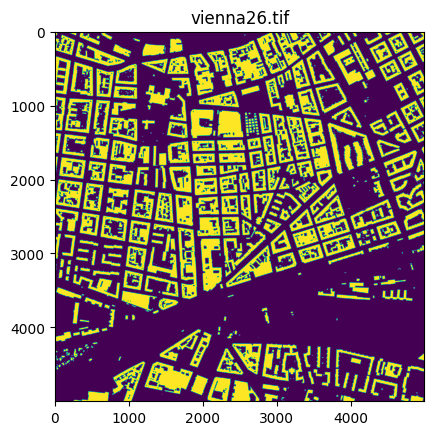

In [3]:
image_path = '/kaggle/input/segmentision-building/AerialImageDataset/train/gt/'
image_files = os.listdir(image_path)
image_file = image_files[0]  # Chọn ảnh đầu tiên trong danh sách
image = Image.open(os.path.join(image_path, image_file))
# Hiển thị ảnh
plt.imshow(image)
plt.title(image_file)
plt.show()

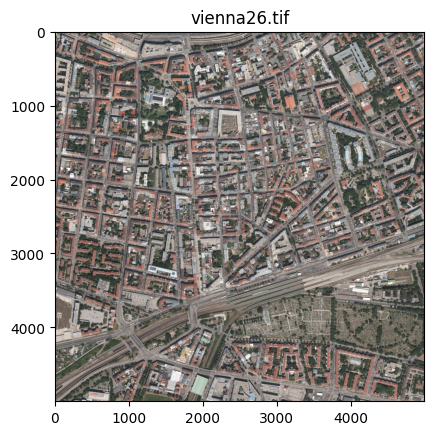

In [4]:
image_path = '/kaggle/input/segmentision-building/AerialImageDataset/train/images/'
image_files = os.listdir(image_path)
image_file = image_files[0]  # Chọn ảnh đầu tiên trong danh sách
image = Image.open(os.path.join(image_path, image_file))
# Hiển thị ảnh
plt.imshow(image)
plt.title(image_file)
plt.show()

In [5]:
!pip install tensorflow opencv-python matplotlib

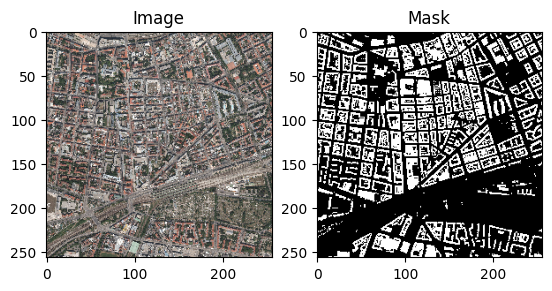

In [6]:


# Đường dẫn đến bộ dữ liệu
train_image_folder = '/kaggle/input/segmentision-building/AerialImageDataset/train/images/'
train_mask_folder = '/kaggle/input/segmentision-building/AerialImageDataset/train/gt/'

# Tiền xử lý ảnh: đọc ảnh và chuyển thành mảng numpy
def load_and_preprocess_image(image_path, mask_path, target_size=(256, 256)):
    # Đọc ảnh và mask
    image = load_img(image_path, target_size=target_size)
    mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
    
    # Chuyển ảnh thành mảng numpy
    image = img_to_array(image) / 255.0  # Chuẩn hóa ảnh
    mask = img_to_array(mask) / 255.0    # Chuẩn hóa mask (0 hoặc 1)
    
    return image, mask

# Lấy tất cả tên tệp ảnh và mask
image_files = os.listdir(train_image_folder)
mask_files = os.listdir(train_mask_folder)

# Chỉ chọn các tệp .tif
image_files = [f for f in image_files if f.endswith('.tif')]
mask_files = [f for f in mask_files if f.endswith('.tif')]

# Ví dụ tải một ảnh và mask
image_path = os.path.join(train_image_folder, image_files[0])
mask_path = os.path.join(train_mask_folder, mask_files[0])
image, mask = load_and_preprocess_image(image_path, mask_path)

# Hiển thị ảnh và mask
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title('Mask')

plt.show()


In [7]:
import tensorflow as tf
from tensorflow.keras import layers
# Xây dựng mô hình U-Net
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    # Decoder
    up3 = layers.UpSampling2D((2, 2))(pool3)
    concat3 = layers.concatenate([up3, conv3], axis=-1)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat3)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    up2 = layers.UpSampling2D((2, 2))(conv4)
    concat2 = layers.concatenate([up2, conv2], axis=-1)
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    up1 = layers.UpSampling2D((2, 2))(conv5)
    concat1 = layers.concatenate([up1, conv1], axis=-1)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv6)
    model = tf.keras.Model(inputs, outputs)
    return model
# Khởi tạo mô hình
model = unet_model()

In [8]:
# Khởi tạo danh sách lưu trữ dữ liệu
train_images = []
train_masks = []

# Lặp qua các ảnh trong thư mục
for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(train_image_folder, image_file)
    mask_path = os.path.join(train_mask_folder, mask_file)
    
    image, mask = load_and_preprocess_image(image_path, mask_path)  # Tiền xử lý ảnh và mask
    
    train_images.append(image)
    train_masks.append(mask)

# Chuyển dữ liệu thành mảng numpy
train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Đảm bảo dữ liệu có kích thước phù hợp (ví dụ: 4D array cho dữ liệu hình ảnh)
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Masks Shape: {train_masks.shape}")


Train Images Shape: (180, 256, 256, 3)
Train Masks Shape: (180, 256, 256, 1)


In [9]:
# Chia bộ dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.1, random_state=42)

# Kiểm tra kích thước
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_val Shape: {X_val.shape}, y_val Shape: {y_val.shape}")


X_train Shape: (162, 256, 256, 3), y_train Shape: (162, 256, 256, 1)
X_val Shape: (18, 256, 256, 3), y_val Shape: (18, 256, 256, 1)


In [10]:
# Huấn luyện mô hình
# Biên dịch mô hình với Adam optimizer và binary crossentropy loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=15, batch_size=8, validation_data=(X_val, y_val))

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8497 - loss: 1.5649 - val_accuracy: 0.8262 - val_loss: 0.5024
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - accuracy: 0.8336 - loss: 0.4830 - val_accuracy: 0.8262 - val_loss: 0.5147
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.8472 - loss: 0.4389 - val_accuracy: 0.8262 - val_loss: 0.4337
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.8303 - loss: 0.4274 - val_accuracy: 0.8262 - val_loss: 0.3653
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.8525 - loss: 0.3502 - val_accuracy: 0.8265 - val_loss: 0.3409
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.8421 - loss: 0.3575 - val_accuracy: 0.8415 - val_loss: 0.3437
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.8541 - loss: 0.3366 - val_accuracy: 0.8545 - val_loss: 0.3350
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.8645 - loss: 0.3306 - val_accuracy: 0.85

In [11]:
# Đánh giá mô hình trên tập kiểm tra
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.8622 - loss: 0.3022
Test Loss: 0.30216237902641296
Test Accuracy: 0.862217366695404


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


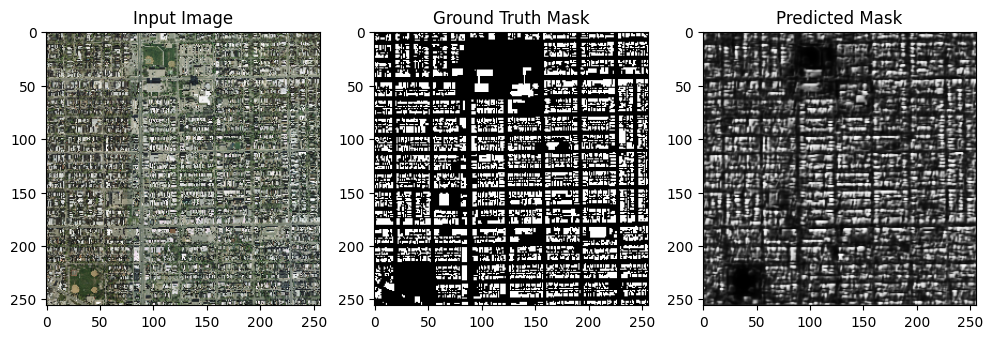

In [12]:
# Dự đoán cho một ảnh trong tập kiểm tra
predictions = model.predict(X_val)

# Chọn một ảnh từ tập kiểm tra
index = 0  # Bạn có thể thay đổi chỉ số ảnh này
image = X_val[index]
mask = y_val[index]
prediction = predictions[index]

# Hiển thị ảnh, mask thực tế và mask dự đoán
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(prediction.squeeze(), cmap='gray')
plt.title('Predicted Mask')

plt.show()

In [13]:


def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder (phần nén ảnh)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Decoder (phần phục hồi kích thước ảnh)
    up3 = layers.UpSampling2D((2, 2))(pool3)  # phục hồi kích thước
    concat3 = layers.concatenate([up3, conv3], axis=-1)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat3)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    up2 = layers.UpSampling2D((2, 2))(conv4)  # phục hồi kích thước
    concat2 = layers.concatenate([up2, conv2], axis=-1)
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up1 = layers.UpSampling2D((2, 2))(conv5)  # phục hồi kích thước
    concat1 = layers.concatenate([up1, conv1], axis=-1)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    conv6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    # Output layer (kích thước ảnh giống với đầu vào)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv6)  # Kích thước (256, 256, 1)

    model = tf.keras.Model(inputs, outputs)
    return model

# Tạo mô hình U-Net
model_finetune = unet_model()

# Biên dịch mô hình
model_finetune.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,             
    restore_best_weights=True  
)
model_finetune.fit(
    X_train, y_train, 
    epochs=50,          
    batch_size=8, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping] 
)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.7222 - loss: 0.6253 - val_accuracy: 0.8262 - val_loss: 0.5587
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.8298 - loss: 0.5100 - val_accuracy: 0.8262 - val_loss: 0.4685
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step - accuracy: 0.8297 - loss: 0.4567 - val_accuracy: 0.8262 - val_loss: 0.4381
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - accuracy: 0.8589 - loss: 0.3906 - val_accuracy: 0.8262 - val_loss: 0.3857
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - accuracy: 0.8522 - loss: 0.3586 - val_accuracy: 0.8262 - val_loss: 0.3473
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - accuracy: 0.8548 - loss: 0.3423 - val_accuracy: 0.8466 - val_loss: 0.3321
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.8542 - loss: 0.3518 - val_accuracy: 0.8468 - val_loss: 0.3338
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.8644 - loss: 0.3192 - val_accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - accuracy: 0.8936 - loss: 0.2438
Test Loss: 0.2437678724527359
Test Accuracy: 0.8935614824295044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


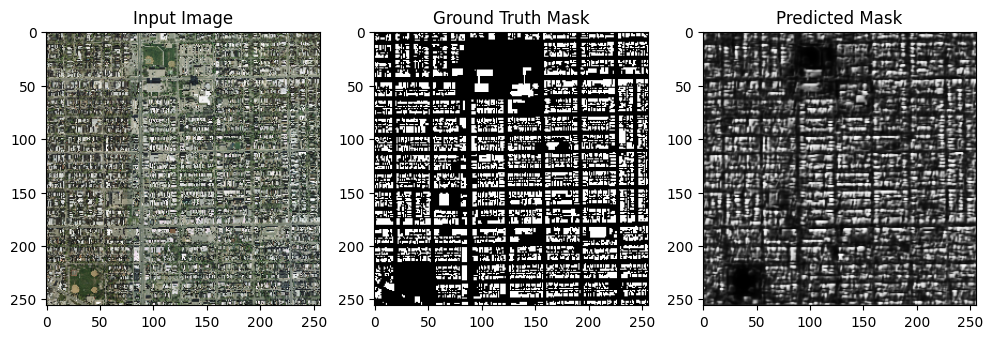

In [15]:
import matplotlib.pyplot as plt
# Đánh giá mô hình trên tập kiểm tra
loss, accuracy = model_finetune.evaluate(X_val, y_val)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Dự đoán cho một ảnh trong tập kiểm tra
predictions = model.predict(X_val)

# Chọn một ảnh từ tập kiểm tra
index = 0  # Bạn có thể thay đổi chỉ số ảnh này
image = X_val[index]
mask = y_val[index]
prediction = predictions[index]

# Hiển thị ảnh, mask thực tế và mask dự đoán
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(prediction.squeeze(), cmap='gray')
plt.title('Predicted Mask')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


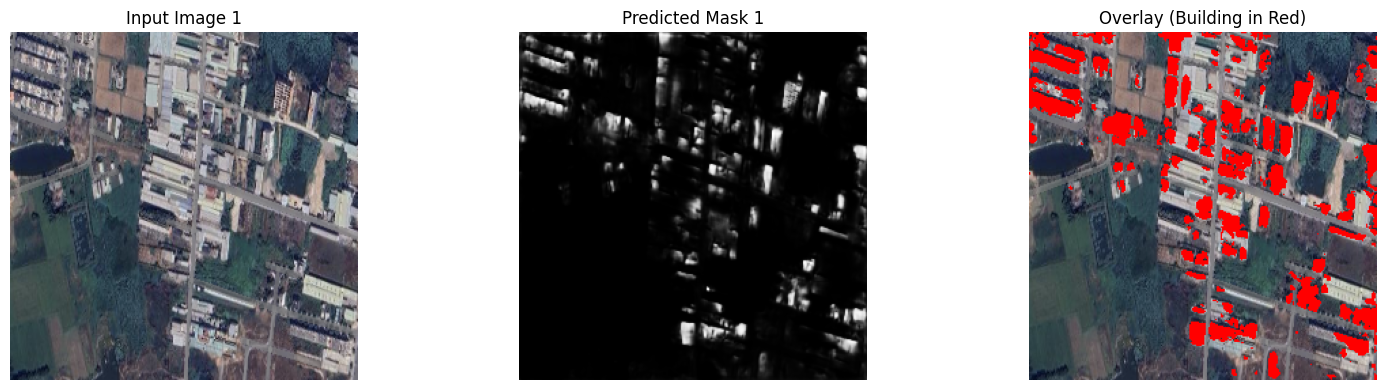

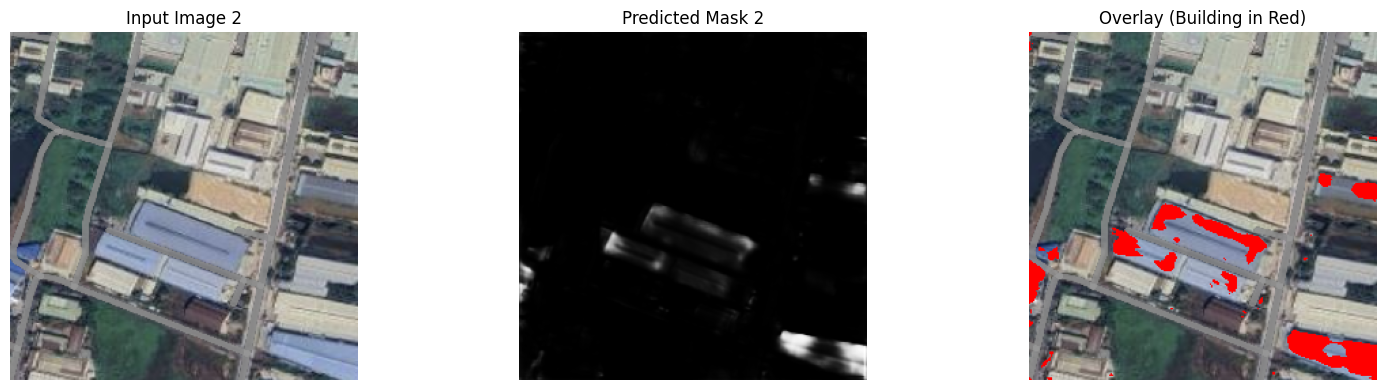

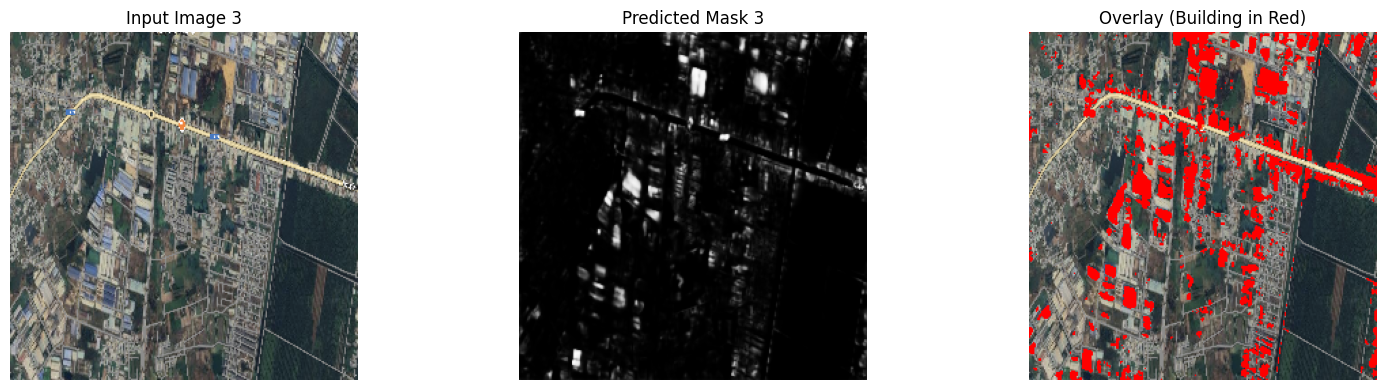

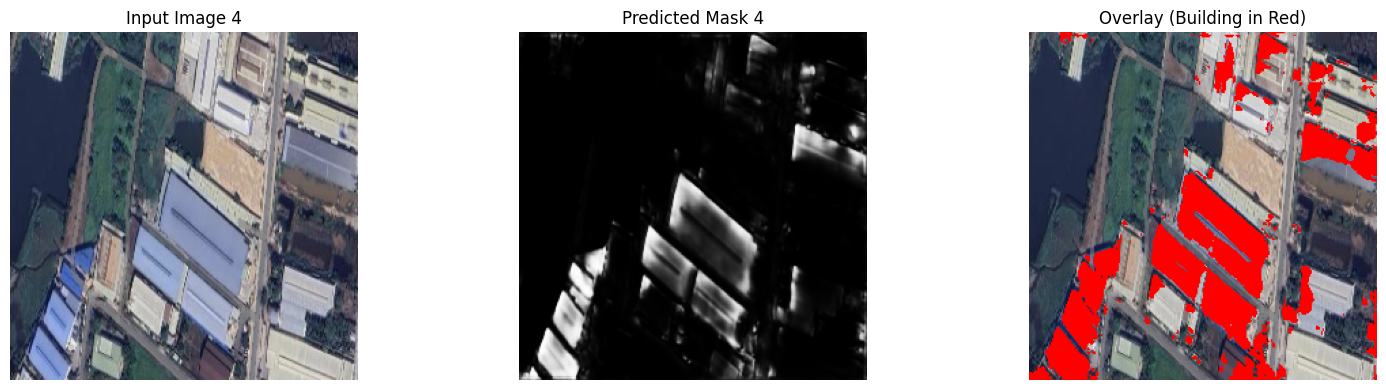

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Đường dẫn đến thư mục ảnh test
test_image_folder = '/kaggle/input/test-thucte/'

# Hàm đọc và tiền xử lý ảnh (resize về kích thước 256x256)
def load_and_preprocess_test_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0  # Chuẩn hóa về 0-1
    return image

# Đọc danh sách file ảnh
test_image_files = os.listdir(test_image_folder)

# Chọn 4 ảnh đầu tiên để test
test_images = []
for image_file in test_image_files[:4]:
    image_path = os.path.join(test_image_folder, image_file)
    image = load_and_preprocess_test_image(image_path)
    test_images.append(image)
test_images = np.array(test_images)

# Dự đoán mask từ mô hình
predictions = model_finetune.predict(test_images)

# Hiển thị kết quả
for i in range(4):
    image = test_images[i]
    prediction = predictions[i].squeeze()

    # Áp dụng threshold để có mask nhị phân
    threshold = 0.09
    binary_mask = (prediction > threshold).astype(np.uint8)

    # Tạo overlay mask màu đỏ
    overlay = image.copy()
    overlay[..., 0] = np.where(binary_mask == 1, 1.0, overlay[..., 0])  # Red channel
    overlay[..., 1] = np.where(binary_mask == 1, 0.0, overlay[..., 1])  # Green channel
    overlay[..., 2] = np.where(binary_mask == 1, 0.0, overlay[..., 2])  # Blue channel

    # Plot ảnh
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f'Input Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction, cmap='gray')
    plt.title(f'Predicted Mask {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f'Overlay (Building in Red)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


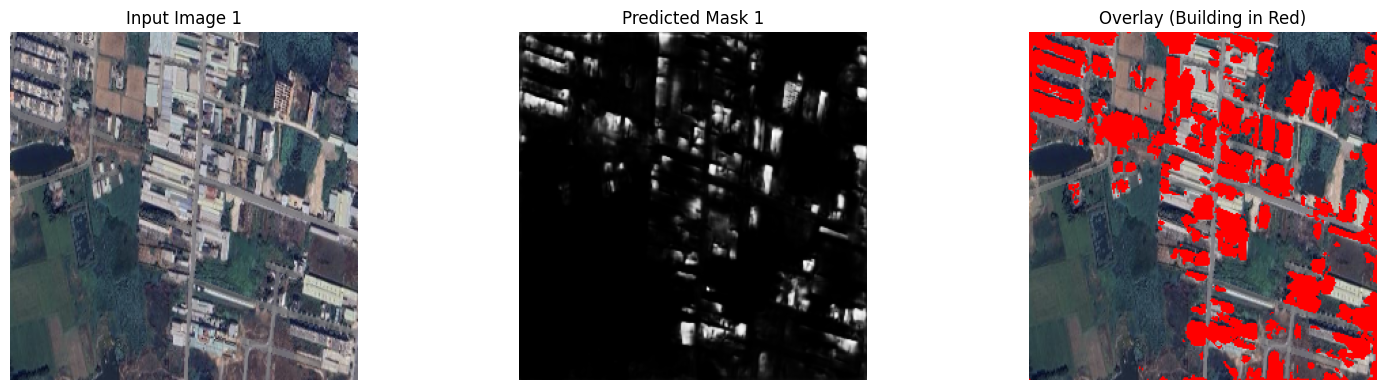

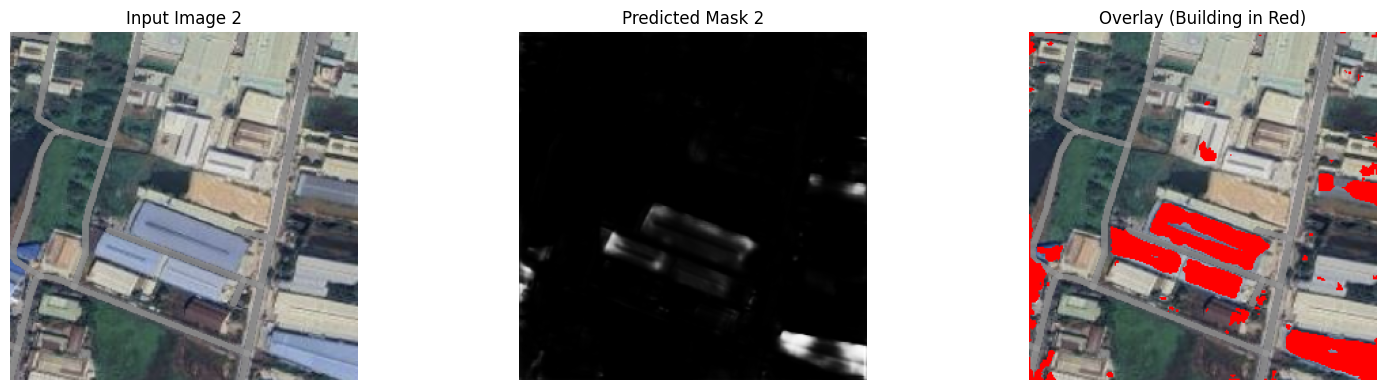

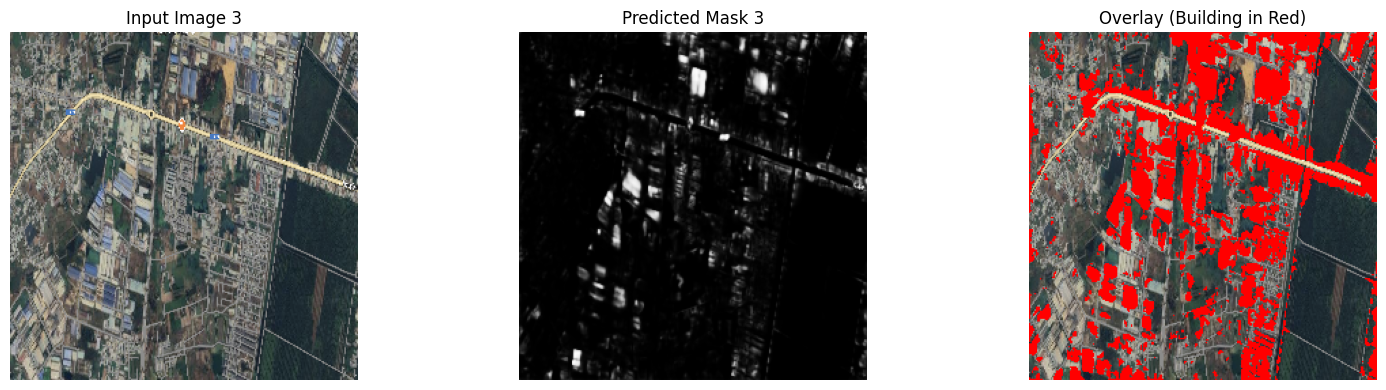

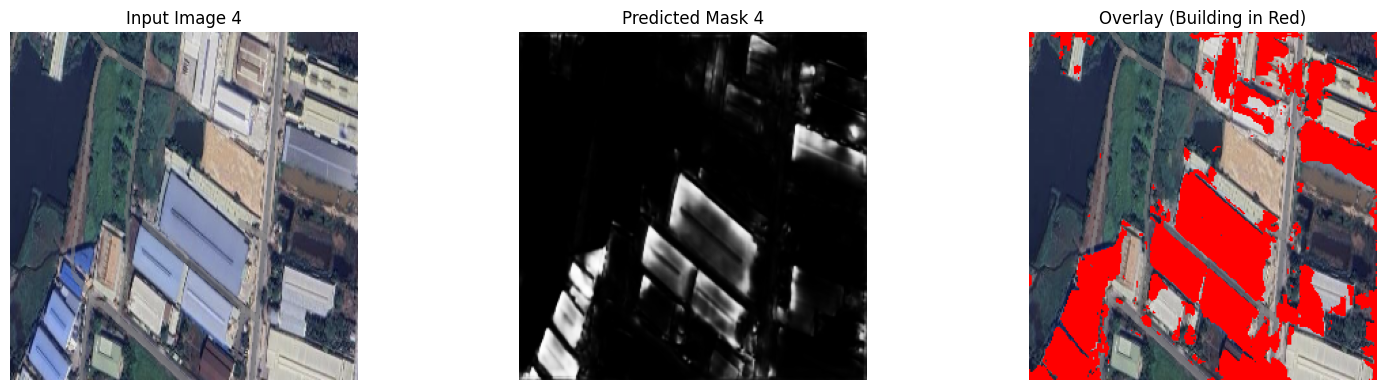

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Đường dẫn đến thư mục ảnh test
test_image_folder = '/kaggle/input/test-thucte/'

# Hàm đọc và tiền xử lý ảnh (resize về kích thước 256x256)
def load_and_preprocess_test_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0  # Chuẩn hóa về 0-1
    return image

# Đọc danh sách file ảnh
test_image_files = os.listdir(test_image_folder)

# Chọn 4 ảnh đầu tiên để test
test_images = []
for image_file in test_image_files[:4]:
    image_path = os.path.join(test_image_folder, image_file)
    image = load_and_preprocess_test_image(image_path)
    test_images.append(image)
test_images = np.array(test_images)

# Dự đoán mask từ mô hình
predictions = model_finetune.predict(test_images)

# Hiển thị kết quả
for i in range(4):
    image = test_images[i]
    prediction = predictions[i].squeeze()

    # Áp dụng threshold để có mask nhị phân
    threshold = 0.03
    binary_mask = (prediction > threshold).astype(np.uint8)

    # Tạo overlay mask màu đỏ
    overlay = image.copy()
    overlay[..., 0] = np.where(binary_mask == 1, 1.0, overlay[..., 0])  # Red channel
    overlay[..., 1] = np.where(binary_mask == 1, 0.0, overlay[..., 1])  # Green channel
    overlay[..., 2] = np.where(binary_mask == 1, 0.0, overlay[..., 2])  # Blue channel

    # Plot ảnh
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f'Input Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction, cmap='gray')
    plt.title(f'Predicted Mask {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f'Overlay (Building in Red)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# FINE TURNING

In [18]:
!pip install -q transformers datasets accelerate
!pip install -q transformers
!pip install -q datasets accelerate


In [19]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from torchvision import transforms
from tqdm import tqdm


In [20]:
# Cấu hình thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Dataset
class BuildingSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, feature_extractor):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.feature_extractor = feature_extractor
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir, self.images[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.masks[idx])).convert("L")
        encoded = self.feature_extractor(images=img, return_tensors="pt")
        pixel_values = encoded["pixel_values"].squeeze()
        mask = mask.resize((pixel_values.shape[2], pixel_values.shape[1]), Image.NEAREST)
        mask = torch.tensor(np.array(mask), dtype=torch.long)
        mask = (mask > 0).long()
        return {"pixel_values": pixel_values, "labels": mask}

# Load dữ liệu
image_dir = '/kaggle/input/segmentision-building/AerialImageDataset/train/images/'
mask_dir = '/kaggle/input/segmentision-building/AerialImageDataset/train/gt/'
feature_extractor = SegformerFeatureExtractor(do_resize=True, size=512, do_normalize=True)
dataset = BuildingSegmentationDataset(image_dir, mask_dir, feature_extractor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Load model
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# Huấn luyện
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.train()
for epoch in range(30):  # Tăng nếu cần
    total_loss = 0
    for batch in tqdm(dataloader):
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 90/90 [01:52<00:00,  1.25s/it]


Epoch 1 - Loss: 52.2984


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 2 - Loss: 37.8795


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 3 - Loss: 32.3328


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 4 - Loss: 29.9313


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 5 - Loss: 27.9844


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 6 - Loss: 26.7459


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 7 - Loss: 26.1669


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 8 - Loss: 25.2118


100%|██████████| 90/90 [01:49<00:00,  1.21s/it]


Epoch 9 - Loss: 24.6473


100%|██████████| 90/90 [01:50<00:00,  1.22s/it]


Epoch 10 - Loss: 24.0224


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 11 - Loss: 23.7257


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 12 - Loss: 23.3881


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 13 - Loss: 22.7413


100%|██████████| 90/90 [01:49<00:00,  1.21s/it]


Epoch 14 - Loss: 22.3769


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 15 - Loss: 22.2689


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 16 - Loss: 21.9736


100%|██████████| 90/90 [01:48<00:00,  1.21s/it]


Epoch 17 - Loss: 21.6954


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 18 - Loss: 21.2658


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 19 - Loss: 21.1273


100%|██████████| 90/90 [01:49<00:00,  1.21s/it]


Epoch 20 - Loss: 21.2847


100%|██████████| 90/90 [01:50<00:00,  1.22s/it]


Epoch 21 - Loss: 20.7364


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 22 - Loss: 20.7961


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 23 - Loss: 20.3099


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 24 - Loss: 20.3358


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 25 - Loss: 20.0244


100%|██████████| 90/90 [01:49<00:00,  1.21s/it]


Epoch 26 - Loss: 19.9648


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 27 - Loss: 19.7164


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 28 - Loss: 19.7023


100%|██████████| 90/90 [01:49<00:00,  1.22s/it]


Epoch 29 - Loss: 19.5485


100%|██████████| 90/90 [01:49<00:00,  1.21s/it]

Epoch 30 - Loss: 19.2598


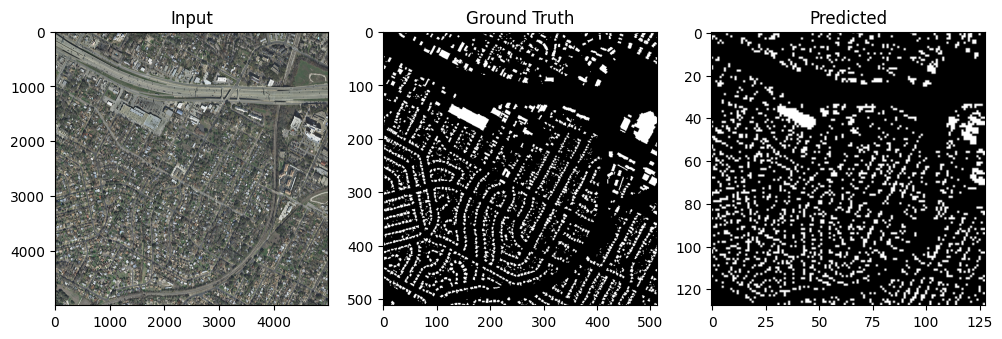

In [21]:
# Dự đoán thử và hiển thị
model.eval()
with torch.no_grad():
    sample = dataset[0]
    inputs = sample["pixel_values"].unsqueeze(0).to(device)
    outputs = model(pixel_values=inputs)
    preds = outputs.logits.argmax(dim=1).squeeze().cpu().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(np.array(Image.open(os.path.join(image_dir, dataset.images[0]))))
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(sample["labels"], cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Predicted")
plt.imshow(preds, cmap="gray")
plt.show()

In [22]:
from glob import glob

# Đảm bảo model ở chế độ eval
model.eval()

# Hàm overlay màu đỏ cho tòa nhà
def show_overlay(image, pred_mask, title="Overlay"):
    overlay = np.array(image).copy()
    red_mask = np.zeros_like(overlay)
    red_mask[pred_mask == 1] = [255, 0, 0]  # Tòa nhà màu đỏ

    blended = np.clip(0.6 * overlay + 0.4 * red_mask, 0, 255).astype(np.uint8)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(title)
    plt.imshow(blended)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Hàm dự đoán và hiển thị
def predict_and_show_from_folder(folder_path, num_samples=3):
    image_paths = sorted(glob(os.path.join(folder_path, "*.jpg")))  # hoặc png nếu ảnh test là PNG
    print(f"\n🔍 Testing folder: {folder_path} ({len(image_paths)} images)")

    for i, img_path in enumerate(image_paths[:num_samples]):
        image = Image.open(img_path).convert("RGB")
        inputs = feature_extractor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            pred = outputs.logits.argmax(dim=1).squeeze().cpu().numpy()

        show_overlay(image, pred, title="Predicted Building Mask (Red Overlay)")

# Thực hiện test trên 2 thư mục
predict_and_show_from_folder("/kaggle/input/test-thucteeee")
predict_and_show_from_folder("/kaggle/input/test-thucte")



🔍 Testing folder: /kaggle/input/test-thucteeee (0 images)

🔍 Testing folder: /kaggle/input/test-thucte (0 images)


In [23]:
model.save_pretrained("model_finetune")